### Carregamento das bibliotecas

In [1]:
# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scikitplot as skplt

# Machine learning 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# balanceamento
from imblearn.under_sampling import RandomUnderSampler

# Grid e Random Search
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_spli
t

# cross validate
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold 
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve

# Selecao de caracteristicas e encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Metricas de avaliacao
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score, plot_roc_curve

# remover warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("files/covid_2021_prepared.csv", sep=';')

___
# IV. Melhoramento do modelo selecionado

In [3]:
def get_ratios(y_train):
    """
        y: y_train ou y_test
        retorna total e porcentagens
    """
    
    df1 = y_train.value_counts().rename_axis('OBITO').reset_index(name='Total')
    df2 = (y_train.value_counts(normalize=True)*100).rename_axis('OBITO').reset_index(name='Porcentagem').drop(columns='OBITO')
    df_concat = pd.concat([df1, df2], axis=1)

    return df_concat

## 1. Dados desbalanceados

### 1.1 Consequências dos dados desbalanceados
Se você está construindo um modelo de machine learning para classificação, por exemplo, a consequência desse desequilíbrio é que o modelo terá uma tendência a dar muitos "alarmes falsos".

Ou seja, na prática ele irá responder muito bem entradas para as classes majoritárias, mas terá um desempenho inferior para as minoriárias.

No exemplo de detecção de fraude com cartões de crédito (onde o número de transações financeiras normais é bem maior que o número de transações fraudulentas), um classificador tenderá a apresentar muitos falsos negativos - uma situação indesejável para um banco, obviamente.

Em um trade-off, seria preferível "errar para mais" e ter uma quantidade maior de falsos positivos. Aliás, aposto que você já teve seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito, não é mesmo?!

Teoricamente, um dataset que possua qualquer classe com mais de 50% das entradas já é considerado desbalanceado. No entanto, há situações extremas onde você vai encontrar proporções maiores que 99:1.

Existem várias abordagens para lidar com dados desbalanceados, cada uma com seus prós e contras. Neste artigo, irei mostrar alguns dos métodos mais populares para você incluir desde já no seu arsenal.

### 1.2 Métodos para lidar com datasets desbalanceados

Há diversas maneiras para atacar o problema de dados desbalanceados, que envolvem desde a construção de algoritmos específicos até a aplicação de algoritmos mais avançados como Recognition-based Learning e Cost-sensitive Learning.

No entanto, uma outra abordagem bem mais simples tem sido amplamente usada (com ótimos resultados), a abordagem *sampling*.

*Sampling* é um pré-processamento que visa minimizar as discrepâncias entre as classes por meio de uma reamostragem do dataset original. Para gerar um conjunto balanceado, são usadas normalmente as seguintes técnicas:

 - Over-sampling: cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de clustering ou sinteticamente.

 - Under-sampling: reduz o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Além dessas duas técnicas de *sampling*, existem também os advanced sampling methods, como SMOTE e ADASYN, onde instâncias são adicionadas ou removidas adaptativamente.

Para isso, podemos usar abordagens que levam em conta apenas a avaliação do modelo, ou técnicas para rebalanceamento como a **undersampling**, que consiste em reamostrar a classe majoritária (nesse caso, recuperado) e manter apenas uma parte desses pontos.

![under sampling](files/resampling.png)

#### *tradeoff*
Ao usar um método de reamostragem (por exemplo, para obter tantos dados de ÓBITO quanto de RECUPERADOS), mostramos as proporções erradas das duas classes para o classificador durante o treinamento. O classificador treinado dessa maneira terá uma precisão menor nos dados de teste reais futuros do que o classificador treinado no conjunto de dados inalterado. Na verdade, as verdadeiras proporções das classes são importantes para saber para classificar um novo ponto e essa informação foi perdida ao reamostrar o conjunto de dados. 

- [Handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)
- [Learning pattern classification tasks with imbalanced data sets](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1806&context=infopapers)
- [There is No Free Lunch in Data Science](https://www.kdnuggets.com/2019/09/no-free-lunch-data-science.html)
- [Imbalanced Classification](https://machinelearningmastery.com/start-here/#imbalanced)

In [4]:
X = df.drop(['EVOLUCAO'], axis=1)
y = df['EVOLUCAO']

In [5]:
# divisao treino test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=777)

In [6]:
get_ratios(y_train)

,OBITO,Total,Porcentagem
0,0,395954,96.819975
1,1,13005,3.180025


In [7]:
get_ratios(y_test)

,OBITO,Total,Porcentagem
0,0,169695,96.819746
1,1,5574,3.180254


### 1.4 Balancear os dados de treino

In [8]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

### 1.4 Teste com dados balanceados

In [9]:
model = XGBClassifier()
model.fit(X_train_rus, y_train_rus)

[21:00:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
from itertools import product

class ConfusionMatrixDisplay:
    def __init__(self, confusion_matrix, *, display_labels=None):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels

    def plot(self, *, include_values=True, cmap='Blues',
             xticks_rotation='horizontal', values_format=None,
             ax=None, colorbar=True):
        
        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        self.text_ = None
        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)

        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)

            # print text with appropriate color depending on background
            thresh = (cm.max() + cm.min()) / 2.0

            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if cm[i, j] < thresh else cmap_min

                if values_format is None:
                    text_cm = format(cm[i, j], '.2g')
                    if cm.dtype.kind != 'f':
                        text_d = format(cm[i, j], 'd')
                        if len(text_d) < len(text_cm):
                            text_cm = text_d
                else:
                    text_cm = format(cm[i, j], values_format)

                self.text_[i, j] = ax.text(
                    j, i, text_cm,
                    ha="center", va="center",
                    color=color)

        if self.display_labels is None:
            display_labels = np.arange(n_classes)
        else:
            display_labels = self.display_labels
        if colorbar:
            fig.colorbar(self.im_, ax=ax)
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=display_labels,
               yticklabels=display_labels,
               ylabel="Valor Real",
               xlabel="Valor Predito")

        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

        self.figure_ = fig
        self.ax_ = ax
        return self

    @classmethod
    def from_estimator(
        cls,
        estimator,
        X,
        y,
        *,
        labels=None,
        sample_weight=None,
        normalize=None,
        display_labels=None,
        include_values=True,
        xticks_rotation="horizontal",
        values_format=None,
        cmap="Blues",
        ax=None,
        colorbar=True,
    ):
        
        method_name = f"{cls.__name__}.from_estimator"
        
        if not is_classifier(estimator):
            raise ValueError(f"{method_name} only supports classifiers")
        y_pred = estimator.predict(X)

        return cls.from_predictions(
            y,
            y_pred,
            sample_weight=sample_weight,
            labels=labels,
            normalize=normalize,
            display_labels=display_labels,
            include_values=include_values,
            cmap=cmap,
            ax=ax,
            xticks_rotation=xticks_rotation,
            values_format=values_format,
            colorbar=colorbar,
        )

    @classmethod
    def from_predictions(
        cls,
        y_true,
        y_pred,
        *,
        labels=None,
        sample_weight=None,
        normalize=None,
        display_labels=None,
        include_values=True,
        xticks_rotation="horizontal",
        values_format=None,
        cmap="Blues",
        ax=None,
        colorbar=True,
    ):

        check_matplotlib_support(f"{cls.__name__}.from_predictions")

        if display_labels is None:
            if labels is None:
                display_labels = unique_labels(y_true, y_pred)
            else:
                display_labels = labels

        cm = confusion_matrix(
            y_true,
            y_pred,
            sample_weight=sample_weight,
            labels=labels,
            normalize=normalize,
        )

        disp = cls(confusion_matrix=cm, display_labels=display_labels)

        return disp.plot(
            include_values=include_values,
            cmap=cmap,
            ax=ax,
            xticks_rotation=xticks_rotation,
            values_format=values_format,
            colorbar=colorbar,
        )


def plot_confusion_matrix_edit(estimator, X, y_true, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='Blues', ax=None, colorbar=True):

    y_pred = estimator.predict(X)
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)

roc_auc_score:  0.9694841558801233


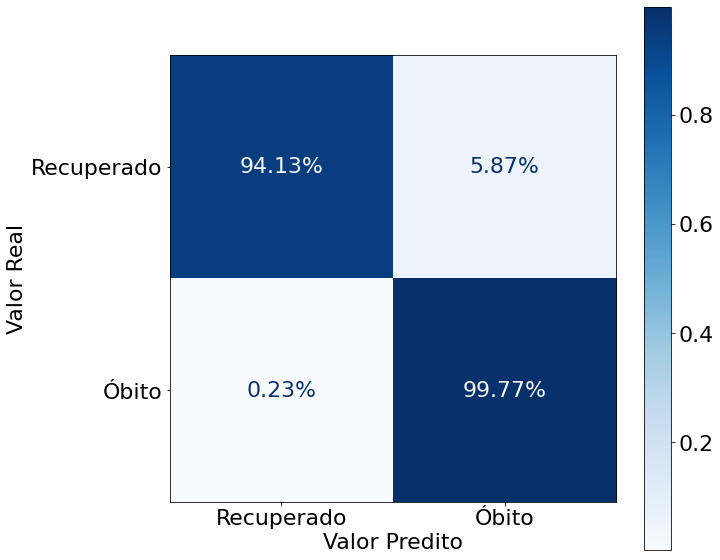

In [11]:
y_pred = model.predict(X_test)
print("roc_auc_score: ", roc_auc_score(y_test, y_pred))
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix_edit(model, X_test, y_test, values_format= '.2%', normalize='true', 
                      display_labels=['Recuperado', 'Óbito'], ax=ax); 

#plt.title("Matriz de confusão")

plt.show()

XGBoost - ORIGINAL
[21:00:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC SCORE: 0.7113569472818817
PRECISION: 0.5825688073394495
RECALL: 0.43290276282741297

XGBoost - BALANCEADO
[21:00:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC SCORE: 0.9694841558801233
PRECISION: 0.35826568741141607
RECALL: 0.9976677430929315


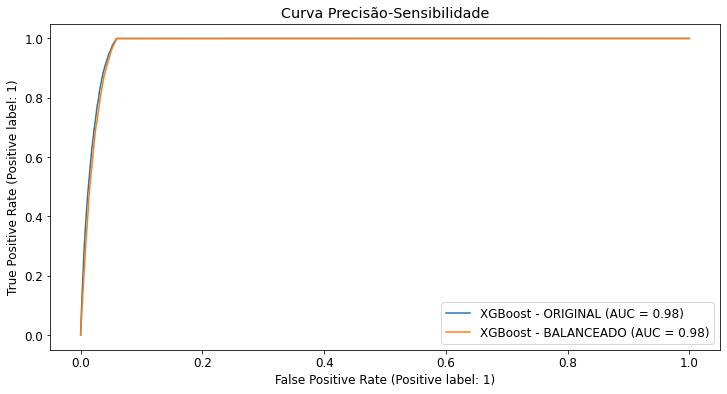

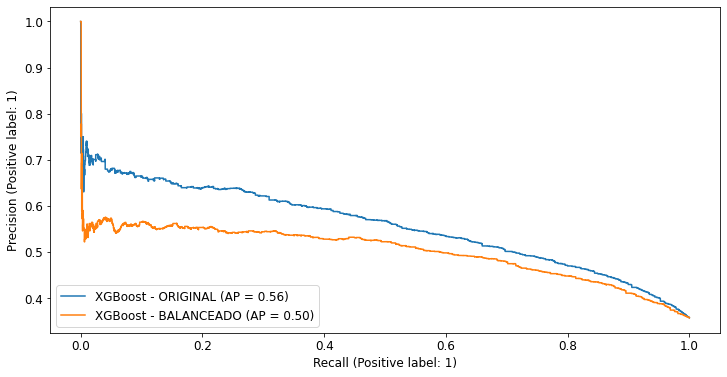

In [12]:
models = [XGBClassifier()]
verbose_models = ['XGBoost']


plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots(figsize=(12, 6))
fig2, ax2 = plt.subplots(figsize=(12, 6))



model_displays = {}

for name, model in zip(verbose_models, models):
    print("===============")
    print(name + " - ORIGINAL")
    
    # ORIGINAL
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # SCORES
    print(f"ROC-AUC SCORE: {roc_auc_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    model_displays[name] = plot_roc_curve(model, X_test, y_test, ax=ax1, name=name + " - ORIGINAL")
    plot_precision_recall_curve(model, X_test, y_test, ax=ax2, name=name + " - ORIGINAL")

    print()
    print(name + " - BALANCEADO")
    
    # BALANCEADO
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    
    # SCORES
    print(f"ROC-AUC SCORE: {roc_auc_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    model_displays[name] = plot_roc_curve(model, X_test, y_test, ax=ax1, name=name + " - BALANCEADO")
    plot_precision_recall_curve(model, X_test, y_test, ax=ax2, name=name + " - BALANCEADO")
    
    print("===============")

_ = ax1.set_title('Curva ROC')
_ = ax2.set_title('Curva Precisão-Sensibilidade')
plt.show()     
    
    

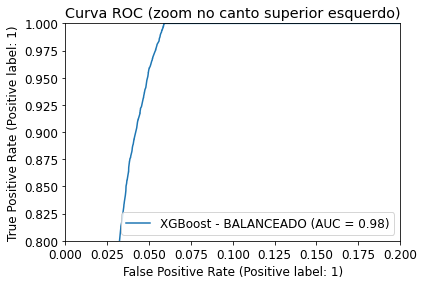

In [13]:
fig, ax = plt.subplots()
for name, model in zip(verbose_models, models):
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title('Curva ROC (zoom no canto superior esquerdo)')

XGBoost - ORIGINAL
[21:04:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC SCORE: 0.7113569472818817
PRECISION: 0.5825688073394495
RECALL: 0.43290276282741297

XGBoost - BALANCEADO
[21:04:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC SCORE: 0.9694841558801233
PRECISION: 0.35826568741141607
RECALL: 0.9976677430929315


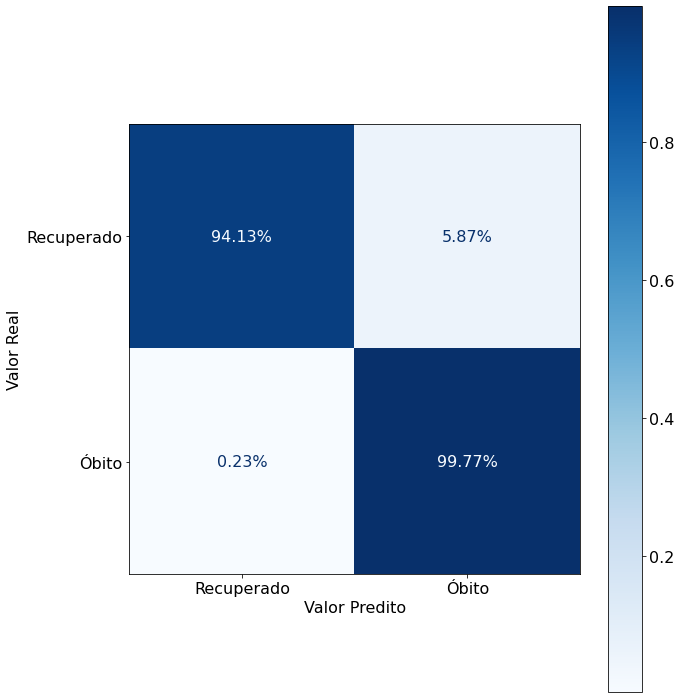

In [19]:
verbose_models = ['XGBoost']

model_displays = {}
plt.rcParams.update({'font.size': 16})
for name, model in zip(verbose_models, models):
    print("===============")
    print(name + " - ORIGINAL")
    
    # ORIGINAL
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # SCORES
    print(f"ROC-AUC SCORE: {roc_auc_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")

    # MATRIZ DE CONFUSAO
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig, ax2 = plt.subplots(figsize=(10, 10))
    
    #plot_confusion_matrix_edit(model, X_test, y_test, values_format= '.2%', normalize='true', 
                      #display_labels=['Recuperado', 'Óbito'], ax=ax1, colorbar=True); 
    
    #ax1.title.set_text(f"Matriz de confusão - {name} \nOriginal")

    print()
    print(name + " - BALANCEADO")
    
    # BALANCEADO
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    
    # SCORES
    print(f"ROC-AUC SCORE: {roc_auc_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")

    plot_confusion_matrix_edit(model, X_test, y_test, values_format= '.2%', normalize='true', 
                      display_labels=['Recuperado', 'Óbito'], ax=ax2); 

    #ax2.title.set_text(f"Matriz de confusão - {name} \nSubamostragem")
    plt.tight_layout()
    plt.show() 
    
    fig.savefig("imgs/confusion_matrix.png")
    
    print("===============")

    